## Work flow for single cell tracing analysis for anatomy MS 2021

__Folder Preparation__

all the required image files are provided under folder with the mouse name<br>
xxx/AL066/<br>
Should have:  <br>
ara2sample/<br>
ara2sample_atlas/<br>
ara2sample_bf/<br>


Some prompt will show up asking for input directory, specific files for downsampled points, and output directory

Find End of section 4, select the text. Then from the menu on top- run- run all above selected cell

Section 1 involves:

4. Identify working with axons(is_axon=1) or not (is_axon=0)
5. read atlas_labels from provided ccf_2017_itksnap.csv provided
6. read in points and get the name of corresponding atlas, outputs points with indices in the corresponding atlas
7. generates tiff stack for points 
8. a) check if points are within the atlas brain (ie. if there are indices of 0 then some points are outside of the brain)
b) correct some of the issue with labeling (see details within the cell)
9. generates .xls files for number of axons in corresponding brain region. (also generate another xls that groups them by parent structure)

_Note that its better to output all .xls files in the same folder ( out_dir) for analysis_ 

10. Section 2: Plot coronal, horizontal and tangential (barrel field) view of non-downsampled points with colours differentiating their location (grey, white and stratum).
11. Section 3: Generate parent.xls from each axon.xls files (from step 9)
12. Section 4: Bar plots of # of axon in specific brain regions for each neuron (sort by most to least amount of parent structure)
13. Section 5: Summary annotated heatmap (points grouped by parent structure from the result of section 3)


In [1]:
import os
import tkinter.filedialog as fdialog
import Neuron_analysis as na
from Neuron_analysis import *
import numpy as np

import pandas as pd
import SimpleITK as sitk

import re

import plotly
import plotly.offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.figure_factory as ff

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
out_dir=fdialog.askdirectory(title='Please select the output directory to store all the results')

In [3]:
atlas_labels=pd.read_csv('ccf_2017_itksnap_labels.csv', sep=',')

## Section 1. generate axon and dendrite excel file
##### run the following session (including the repeat of axon and dendrite) for each brain

In [4]:
##point of manual work here! repeat for each brain
in_dir = fdialog.askdirectory(title='Please select the folder with mouse name')
# ie: D:\xxxx\AL066

In [5]:
mouse_name=na.find_mousename(in_dir)
out_name=os.path.join(out_dir ,mouse_name)
mouse_name

'AL110'

In [6]:
all_files=os.listdir(in_dir)
axon=[i for i in all_files if f'{mouse_name}_25.0voxel_trace' in i]
dendrite=[i for i in all_files if f'{mouse_name}D_25.0voxel_trace' in i]
axon=os.path.join(in_dir, axon[0])
dendrite=os.path.join(in_dir, dendrite[0])


### Section 1.1
#### change is_axon=1 and then 0 for dendrite and run the rest of the code up until indicated point

In [7]:
##point of manual work here
is_axon=1

if is_axon==1:
    file_type=axon
elif is_axon==0:
    file_type=dendrite
# put 0 if working with dendrites`and repea the following cells for each neuron

In [8]:
# Two useful functions
def check_points(points_in_atlas):
    '''Checks whether all your points' ID is within the atlas labels
    Input: matching ID of the points (this is the second output from na.make_pd)
    '''
    id_inatlas=[]
    for x in atlas_labels['region_id']:
        intID = int(x)
        id_inatlas.append(intID)

    # need to format this first ourselves,otherwise problematic for 0 and very large numbers (idk why)    

    num_of_zeros = [i for i, x in enumerate(points_in_atlas) if x == 0]
    # find the indices for which carries an id =0
    
    unique_id=set(points_in_atlas)
    
    for id_inbrain in unique_id:
        if id_inbrain not in id_inatlas:
            if id_inbrain==0:
                print(f'There are {len(num_of_zeros)} points with ID= {id_inbrain}, this index is outside of the brain, consider possible suboptimal image registration')
            else: 
                print(id_inbrain,'this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37')
    return 


In [9]:
points,atlas_name=na.get_pt_natlas(file_type,in_dir)
# read points and get path name of the corresponding atlas

In [10]:
if is_axon :
    na.atlas.make_tif_1(points, atlas_name,os.path.join(out_dir, mouse_name), is_axon)
else:
    na.atlas.make_tif(points, atlas_name,os.path.join(out_dir, mouse_name), is_axon)
# save points as a tiff file for visualization and overlay
# for dendrites, keep the intensities different since...its too cramped up and will look bad!

Starting to saving tif files..


C:\Users\liu\Neuron_analysis\atlas.py:163: UserWarning:

D:/Complete_points\AL110_axons.tif is a low contrast image



In [11]:
points_in_atlas= na.points.find_point_id (points,atlas_name)

In [12]:
check_points(points_in_atlas)
#we should only see id=0 as possibility now since now is using the itksnap_wraped atlas

In [13]:
points_in_atlas= np.where(points_in_atlas==0, 844, points_in_atlas) 
# replace id= 0 with 844 (ssp-bfd layer1)

if is_axon :
    points_in_atlas= np.where(points_in_atlas==800 , 215 , points_in_atlas) 
    points_in_atlas= np.where(points_in_atlas==1092 , 215 , points_in_atlas)
    # replace id= 800 (subependymal zone) and 1092 (lateral ventricle) with 215(caudoputamen)
    # especially for AL131
    
    points_in_atlas= np.where(points_in_atlas==1242, 1296 , points_in_atlas) 
    points_in_atlas= np.where(points_in_atlas==1127, 1296 , points_in_atlas)
    # replace id= 1242 (optic radiation)  and id= 1127 (auditory radiation) with 1296, stc(a subregion of fiber bundle)
    # these are intrinsic issue of the allen atlas, the labels for these regions are wrong

check_points(points_in_atlas)
# check again to see if 0 disappears

In [14]:
if is_axon :
    points_in_atlas= np.where(points_in_atlas==800 , 215 , points_in_atlas) 
    points_in_atlas= np.where(points_in_atlas==1092 , 215 , points_in_atlas)
    # replace id= 800 (subependymal zone) and 1092 (lateral ventricle) with 215(caudoputamen)
    # especially for AL131
    
    points_in_atlas= np.where(points_in_atlas==1242, 1296 , points_in_atlas) 
    points_in_atlas= np.where(points_in_atlas==1127, 1296 , points_in_atlas)
    # replace id= 1242 (optic radiation)  and id= 1127 (auditory radiation) with 1296, stc(a subregion of fiber bundle)
    # these are intrinsic issue of the allen atlas, the labels for these regions are wrong

check_points(points_in_atlas)
# check again to see if 0 disappears

In [15]:
region_counts=na.points.make_pd_ara2sample(points_in_atlas.tolist(),atlas_labels,out_name,is_axon)
# This gives an excel file identifying number of points in a given region


C:\Users\liu\Neuron_analysis\points.py:235: FutureWarning:

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.



In [16]:
##### step below: associated region id on origional(non-downsampled and non-transformed) annotation (converted to um units and resampled to 1um steps)


points_original=[i for i in all_files if f'{mouse_name}_stamp' in i]
points_original= os.path.join(in_dir, points_original[0])
#points_original= fdialog.askopenfilename(title='Selecte the original resampled points for axons')
# asks for the non-downsampled annotation, usually the eswc file that has been converted to um and resampled at 1 um steps
# provided within the same folder of the mouse name
# and with name called ...converted...resampled.eswc

original_withID=na.points.findID_origional(points_original, points_in_atlas,out_name,is_axon)
#makes a csv file with original points and their associated id

In [17]:
# repeat everything for dendrite
is_axon=0
if is_axon==1:
    file_type=axon
elif is_axon==0:
    file_type=dendrite

In [18]:
# repeat everything for dendrite

points,atlas_name=na.get_pt_natlas(file_type,in_dir)
# read points and get path name of the corresponding atlas
    
if is_axon :
    na.atlas.make_tif_1(points, atlas_name,os.path.join(out_dir, mouse_name), is_axon)
else:
    na.atlas.make_tif(points, atlas_name,os.path.join(out_dir, mouse_name), is_axon)
# save points as a tiff file for visualization and overlay
# for dendrites, keep the intensities different since...its too cramped up and will look bad!

points_in_atlas= na.points.find_point_id (points,atlas_name)

check_points(points_in_atlas)
#we should only see id=0 as possibility now since now is using the itksnap_wraped atlas
points_in_atlas= np.where(points_in_atlas==0, 844, points_in_atlas) 
# replace id= 0 with 844 (ssp-bfd layer1)

Starting to saving tif files..


C:\Users\liu\Neuron_analysis\atlas.py:112: UserWarning:

D:/Complete_points\AL110_dendrites.tif is a low contrast image



There are 5 points with ID= 0, this index is outside of the brain, consider possible suboptimal image registration


In [19]:
points_in_atlas= np.where(points_in_atlas==0, 844, points_in_atlas) 
# replace id= 0 with 844 (ssp-bfd layer1)

In [20]:
check_points(points_in_atlas)
# check again to see if 0 disappears
region_counts=na.points.make_pd_ara2sample(points_in_atlas.tolist(),atlas_labels,out_name,is_axon)
# This gives an excel file identifying number of points in a given region

In [21]:
##### step below: associated region id on origional(non-downsampled and non-transformed) annotation (converted to um units and resampled to 1um steps)

points_original=[i for i in all_files if f'{mouse_name}D_stamp' in i]
points_original=os.path.join(in_dir, points_original[0])

original_withID=na.points.findID_origional(points_original, points_in_atlas,out_name,is_axon)
#makes a csv file with original points and their associated id

In [22]:
mouse_name

'AL110'

##### stop here for axon and dendrite quantification

## End of section 1
Repeat the above cells to have two excel files(axons and dendite) for all neuron. 

## Section 2:  Plot coronal, horizontal and bf view in higher resolution

with different colours for axons in grey matter, white matter, or striatum

Same ideas for dendrite but all dendrite are in grey matter, so it would be a simplified code for them

In [23]:
import matplotlib.pyplot as plt
import tkinter.filedialog as fdialog

import math


In [24]:
#out_dir=fdialog.askdirectory(title='Please select the output directory to store all the results')


In [25]:
#atlas_labels=pd.read_csv('ccf_2017_itksnap_labels.csv', sep=',')


In [26]:
ori_pointsID= fdialog.askopenfilename(initialdir=out_dir, title='Selecte the original resampled points with ID excel file for axons')
mouse_name= na.find_mousename(ori_pointsID)
mouse_name

'AL110'

In [27]:
original_withID= pd.read_csv (ori_pointsID)
original_withID.head()

,x,y,z,atlasID
0,4553.51,1962.31,3650.00,844
1,4552.53,1962.41,3649.85,844
2,4551.54,1962.51,3649.69,844
3,4550.56,1962.61,3649.54,844
4,4549.91,1962.77,3649.08,844


In [28]:
full_label=pd.merge(na.atlas_labels, atlas_labels, on = 'acronym')

In [29]:
fiber_tracts=full_label[full_label['structure_id_path'].str.contains("1009")].region_id
fiber_tracts=fiber_tracts.tolist()

In [30]:
striatum=full_label[full_label['structure_id_path'].str.contains("477")].region_id
striatum=striatum.tolist()

In [31]:
white=original_withID.loc[original_withID['atlasID'].isin(fiber_tracts)]
grey=original_withID.loc[~original_withID['atlasID'].isin(fiber_tracts) & ~original_withID['atlasID'].isin(striatum)]
stri=original_withID.loc[original_withID['atlasID'].isin(striatum)]

In [32]:
xg= pd.to_numeric(grey['x']).round()
yg= pd.to_numeric(grey['y']).round()
zg= pd.to_numeric(grey['z']).round()

xw= pd.to_numeric(white['x']).round()
yw= pd.to_numeric(white['y']).round()
zw= pd.to_numeric(white['z']).round()

xs= pd.to_numeric(stri['x']).round()
ys= pd.to_numeric(stri['y']).round()
zs= pd.to_numeric(stri['z']).round()

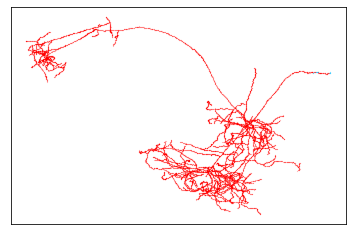

In [33]:
plt.scatter(xg[::5], yg[::5],s=0.01, c='red')
plt.scatter(xw[::5], yw[::5], s= 0.01, c= 'deepskyblue')
plt.scatter(xs[::5], ys[::5], s= 0.01, c= 'lime')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.savefig(out_name+"_c_axons.svg", format='svg')

plt.show()

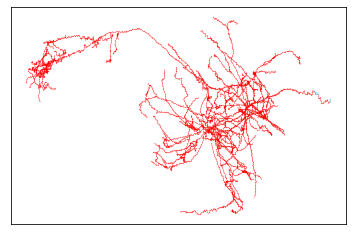

In [34]:
plt.scatter(xg[::5], zg[::5],s=0.01, c='red')
plt.scatter(xw[::5], zw[::5], s= 0.01, c= 'deepskyblue')
plt.scatter(xs[::5], zs[::5], s= 0.01, c= 'lime')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.savefig(out_name+"_h_axons.svg", format='svg')
plt.show()
#horizontal view

In [35]:
def rotate(x,y,xo,yo,degrees): #rotate x,y around xo,yo by x degrees
    theta = np.deg2rad(degrees) # convert degrees to rad
    xr=math.cos(theta)*(x-xo)-math.sin(theta)*(y-yo)  + xo
    yr=math.sin(theta)*(x-xo)+math.cos(theta)*(y-yo)  + yo
    return [xr,yr]

In [36]:
list_xy= list(zip(xg,yg))
list_xy[1]
rot_xg=[]
rot_yg=[]
for i in list_xy:
    x= i[0]
    y= i[1]
    newx,newy= rotate(x,y,0,0,30)
    rot_xg.append(newx)
    rot_yg.append(newy)

list_xy= []

In [37]:
if xw.empty:
    rot_xw=[]
    rot_yw=[]
else: 
    list_xy= list(zip(xw,yw))
    list_xy[1]
    rot_xw=[]
    rot_yw=[]
    for i in list_xy:
        x= i[0]
        y= i[1]
        newx,newy= rotate(x,y,0,0,30)
        rot_xw.append(newx)
        rot_yw.append(newy)

    list_xy= []

In [38]:
if xs.empty:
    rot_xs=[]
    rot_ys=[]
else:
    list_xy= list(zip(xs,ys))
    list_xy[1]
    rot_xs=[]
    rot_ys=[]
    for i in list_xy:
        x= i[0]
        y= i[1]
        newx,newy= rotate(x,y,0,0,30)
        rot_xs.append(newx)
        rot_ys.append(newy)

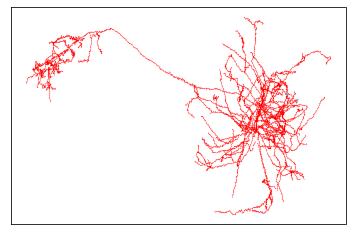

In [39]:
plt.scatter(rot_xg[::5], zg[::5],s=0.01, c='red')
plt.scatter(rot_xw[::5], zw[::5], s= 0.01, c= 'deepskyblue')
plt.scatter(rot_xs[::5], zs[::5], s= 0.01, c= 'lime')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.savefig(out_name+"_bf_axons.svg", format='svg')
plt.show()

## end of section 2

## Section 3
The below section then talkes a folder containing all excel file resulting from section 1

For each axonal excel file, merge subregions with the common parent region (ie, SSp-bfd Layers 1, 2/3, 4, etc becomes SSp-bfd), then save as another excel file named ALxxx_parent.xls

In [40]:
files= os.listdir(out_dir)
axon_files=[os.path.join(out_dir ,i) for i in files if 'axons_region_with_counts' in i]
#all_mice= set([na.find_mousename(i) for i in axon_files])
#all_mice=list(all_mice)

this_mouse= [i for i in axon_files if mouse_name in i]

#out_dir= 'D:\\Complete_points\\'

In [41]:
def parent_df(df):
    # group dataframe by parent id structure
    grouped_pd=df.groupby(['parent_structure_id'],as_index=False).sum()
    d= {'id': grouped_pd.parent_structure_id.astype(int), 'Total_counts': grouped_pd.Total_counts}
    grouped_pd2= pd.DataFrame(data=d)
    result = pd.merge(grouped_pd2, na.atlas_labels, on=["id"])
    result.sort_values(['Total_counts'], ascending=True, inplace=True)
    # result is the final pd
    return result

In [42]:
# Creates pd with parent structure (1 level up) for all

axon_bar=pd.read_excel(this_mouse[0]).sort_values(by=['Total_counts'])
new_axonpd= na.atlas_labels.merge(axon_bar, on= 'acronym')
new_axonpd.sort_values(by= 'graph_order',axis=0, inplace=True)
result= parent_df(new_axonpd)
out_name=os.path.join(out_dir ,mouse_name)
result.to_excel(f'{out_name}_parent.xls')  

D:\anaconda\envs\anatomy\lib\site-packages\ipykernel_launcher.py:8: FutureWarning:

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.



In [43]:
mouse_name

'AL110'

## End of section 3

## Section 4: Makes individual bar graph ##
Point of manual input of mouse name here #
repeat until the end of the section

In [44]:
files=[os.path.join(out_dir ,i) for i in files if 'region_with_counts' in i]
mouse_name

'AL110'

In [45]:
# point of manual work here..repeat for individual mice
test= [i for i in files if re.search(mouse_name, i) ] # Need to manually enter the mouse identifier, or write a loop looping through them
axon= test[0]
dendrite=test[1]
out_name=os.path.join(out_dir ,mouse_name)

In [46]:
axon_bar=pd.read_excel(axon).sort_values(by=['Total_counts'])
dendrite_bar=pd.read_excel(dendrite).sort_values(by=['Total_counts'])

In [47]:
new_axonpd= na.atlas_labels.merge(axon_bar, on= 'acronym')
new_axonpd.sort_values(by= 'graph_order',axis=0, inplace=True)

In [48]:
new_dendritepd= na.atlas_labels.merge(dendrite_bar, on= 'acronym')
new_dendritepd.sort_values(by= 'Total_counts',axis=0, inplace=True)

order by total amount of a parent region 

In [49]:
def parent_df(df):
    # group dataframe by parent id structure
    grouped_pd=df.groupby(['parent_structure_id'],as_index=False).sum()
    d= {'id': grouped_pd.parent_structure_id.astype(int), 'Total_counts': grouped_pd.Total_counts}
    grouped_pd2= pd.DataFrame(data=d)
    result = pd.merge(grouped_pd2, na.atlas_labels, on=["id"])
    result.sort_values(['Total_counts'], ascending=True, inplace=True)
    # result is the final pd

    return result

In [50]:
result= parent_df(new_axonpd)
new_order=result.id.to_numpy()
#new_order

In [51]:
old_order= new_axonpd.parent_structure_id.to_numpy()   
#old_order

In [52]:
new_array= np.zeros_like(old_order)
for i, j in enumerate(new_order):
    new_array[old_order==j]=i

#new_array
# generate new order for the detailed pd

In [53]:
new_axonpd['new_order']= new_array
new_axonpd.sort_values('new_order', inplace=True)

In [54]:
new_axonpd.sort_values(by=['new_order', 'region_id'], ascending=[True, False] ,inplace=True)
# sort by new order first (total amount within the same parent id), and then within each substructure, sort by layer 1 to layer 6

In [55]:
def plot_hist(pd_axon, pd_dendrite, mousename):
    ''' 
    Plot horizontal histogram of all points and ending points of axons and dendrites
    Input: pandas dataframe of axon, pandas dataframe of dendrite, mousename
    '''
    y=pd_axon['acronym']
    fig = make_subplots(
        shared_yaxes=True,
        rows=2, cols=1,
        row_heights=[0.9, 0.1],
        row_titles=['Axons', 'Dendrites']
    )
    fig.add_trace(
        go.Bar(
        y=y, x=pd_axon['Total_counts']/1000, # units now in milimeters
        marker_color='red', #for future, pd_axon['region_id'],
        name='',
        #text=pd_axon['name'],
        hovertemplate=
            '<i>%{x}</i>, '+
            '<b>%{text}</b>',
        orientation='h'),
        row=1,col=1
    )
    

    z=pd_dendrite['acronym']
    fig.add_trace(
        go.Bar(
        y=z, x=pd_dendrite['Total_counts']/1000, # units now in milimeters
        marker_color='black',
        name='',
        #text=pd_dendrite['name'],
        hovertemplate=
        '<i>%{x}</i>, '+
        '<b>%{text}</b>',
        orientation='h'),
        row=2,col=1
    )

    
    fig.update_layout(yaxis={'categoryorder':'trace'}, 
                      width=2000,
                      height=1000, # 1500 for AL066 since too many items
                      showlegend= False,
                      paper_bgcolor='rgba(0,0,0,0)', # transparent background
                      plot_bgcolor='rgba(0,0,0,0)' # transparent background
                     )
    
    fig.update_xaxes(gridcolor='gold')
    
    fig.show()
    # plotly.offline.plot(fig,filename='D:/'+ mousename+'/barplot.html')
    fig.write_image(f"{out_name}.svg")
    fig.write_html(f"{out_name}.html")

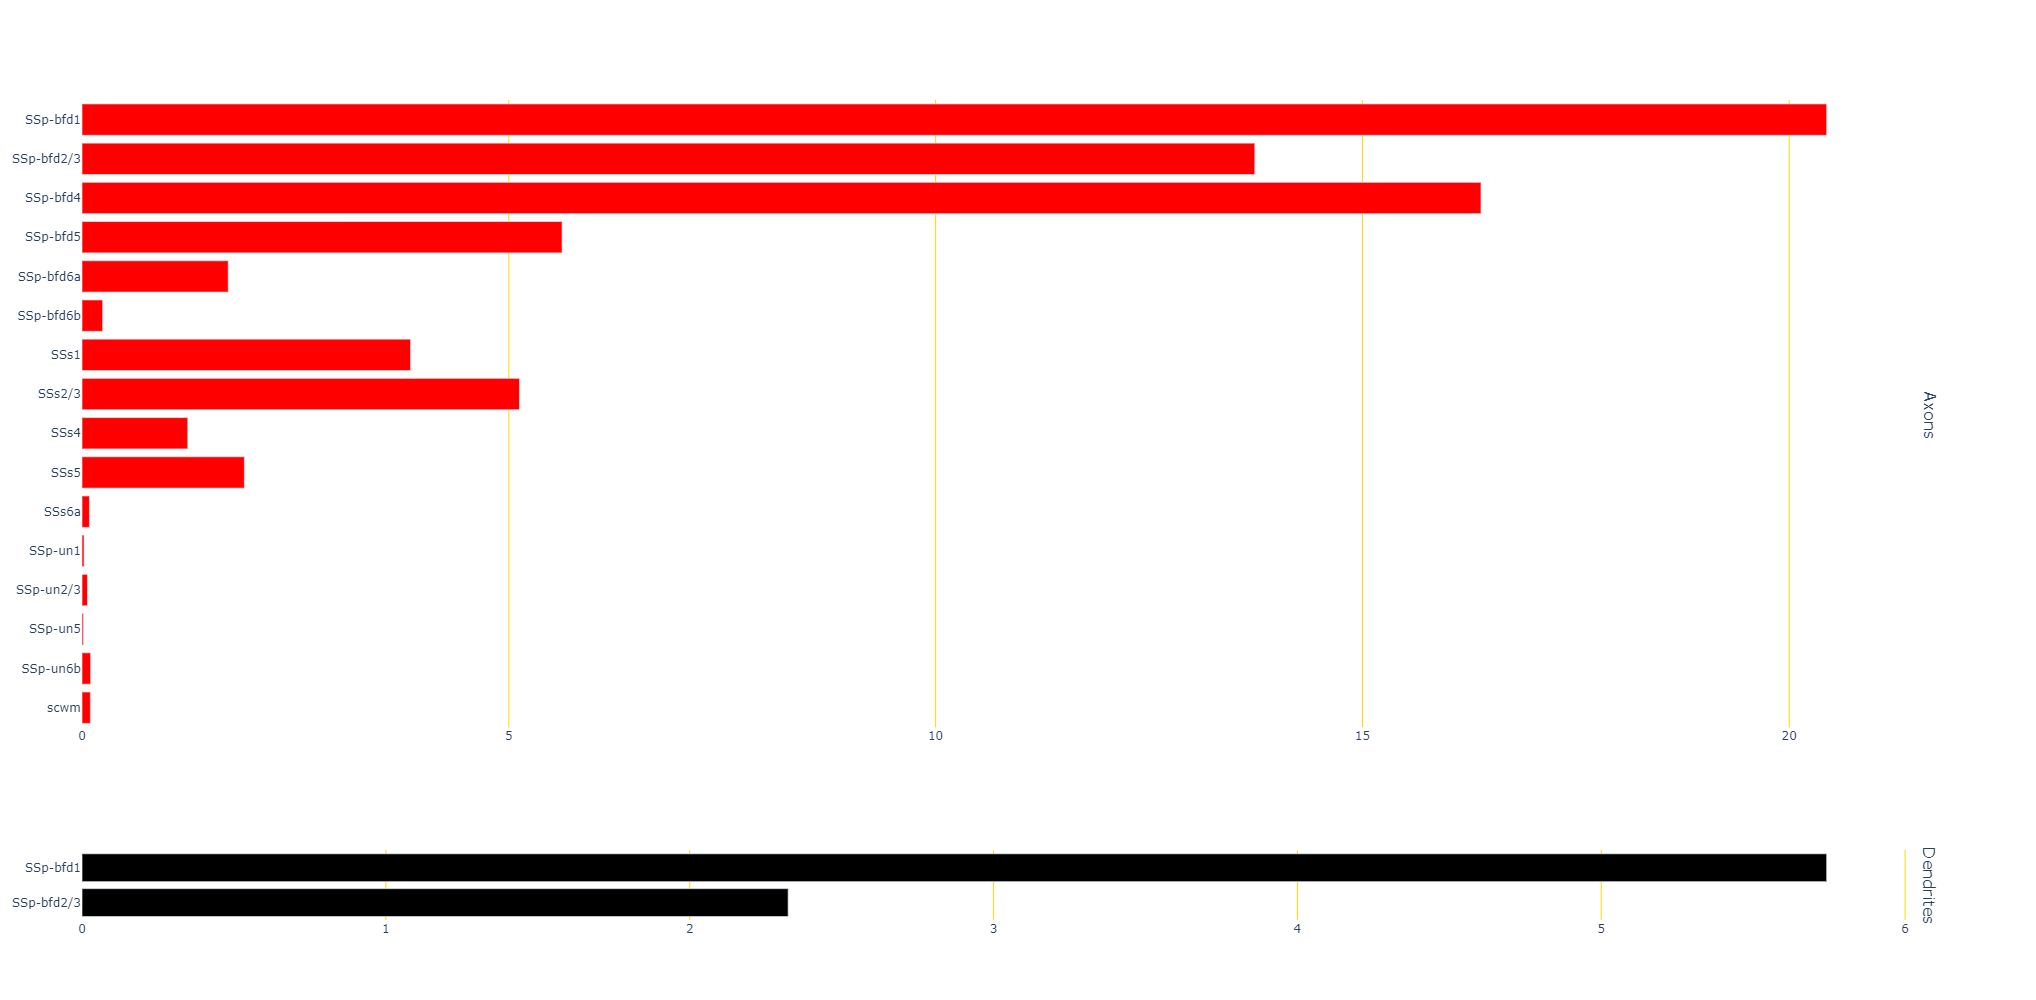

In [56]:
plot_hist(new_axonpd,new_dendritepd,mouse_name)


## End of section 4

## Section 5
Final summary annotated heatmap from a folder containing all of the _parents.xls

In [74]:
#define useful functions

def prep_df(df):
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    
    new= read_file.set_index('acronym').T
    new_series=new.loc['Total_counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'Total_counts': na.find_mousename(df)}, inplace=1)
    return full_df

def combine_df(folder,list_of_fname,inner=False):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_name_initial=os.path.join(folder, list_of_fname[0])
    full_df=prep_df(full_name_initial)
    
    if inner==True:
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1, join='inner')

    else: 
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1)

    full_df=full_df.T.iloc[1:]
    return full_df

def sort_id(df):
    #pick out id that are present in the df and sort them by graph order
    #this puts relevant regions together(ie, all layers of S1bf will be together, etc)
    atlas_ref=na.atlas_labels[na.atlas_labels['id'].isin(df.columns)]
    sorted_id=[x for _,x in sorted(zip(atlas_ref['graph_order'],atlas_ref['id']))]
    return sorted_id

In [75]:
#find all relevant files

files= [ i for i  in os.listdir(out_dir) if 'with_counts' in i]
parent_axons= [ i for i  in os.listdir(out_dir) if 'parent' in i]

In [76]:
axonal_df= combine_df(out_dir, parent_axons)
# keep Nan for heatmap display purposes


In [77]:
axonal_df.sort_index(axis=1)
new_colorder= axonal_df.sum()
# new column order would be the region with greatest amount goes first, ie: bfd, trunk, visc, etc

new_colorder.sort_values(ascending=False, inplace=True)
# finds the new coloumn order
axonal_df=axonal_df[new_colorder.index]
# sort by new column order

In [78]:
axonal_df.shape

(2, 12)

In [79]:
average= axonal_df.sum()/axonal_df.shape[0]
# 10 cells in total
avg=average.to_numpy()

avg=np.reshape(avg,(1,axonal_df.shape[1]))
# 28 region item in total
avg.shape

df_average = pd.DataFrame(avg, columns=axonal_df.columns, index=['Average'])
df_average

acronym,SSp-bfd,SSs,VISrl,VISa,VISam,st,VISp,cc,SSp-tr,SSp-un,fiber tracts,mfbc
Average,53258.0,7964.5,2568.5,1141.0,878.5,521.5,380.0,367.0,342.5,132.5,89.5,46.5


In [80]:
final= axonal_df.append(df_average)
final.to_excel(out_dir+'/axonal_df_parent.xls')

final=final[::-1] 
# so that average row shows up last when plotting

D:\anaconda\envs\anatomy\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.



In [81]:
# Dataframe preparation done, now to plot annotated heatmap
x=final.columns.to_list()
y=final.index.to_list()

full_name=[]
for i in x:
    name=na.atlas_labels.query(f"acronym== '{i}'").name.values[0]
    full_name.append(name)
# get full name

In [82]:
parent_acronyms= {'Acronyms': x, 'Full name': full_name}
acronym_df= pd.DataFrame(data=parent_acronyms)
acronym_df.to_excel(out_dir+'/acronym_parent.xls')
# Generate an excel file of acronyms as well as their full name (for list of acronym in appendix)

D:\anaconda\envs\anatomy\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.



D:\anaconda\envs\anatomy\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning:

invalid value encountered in reduce



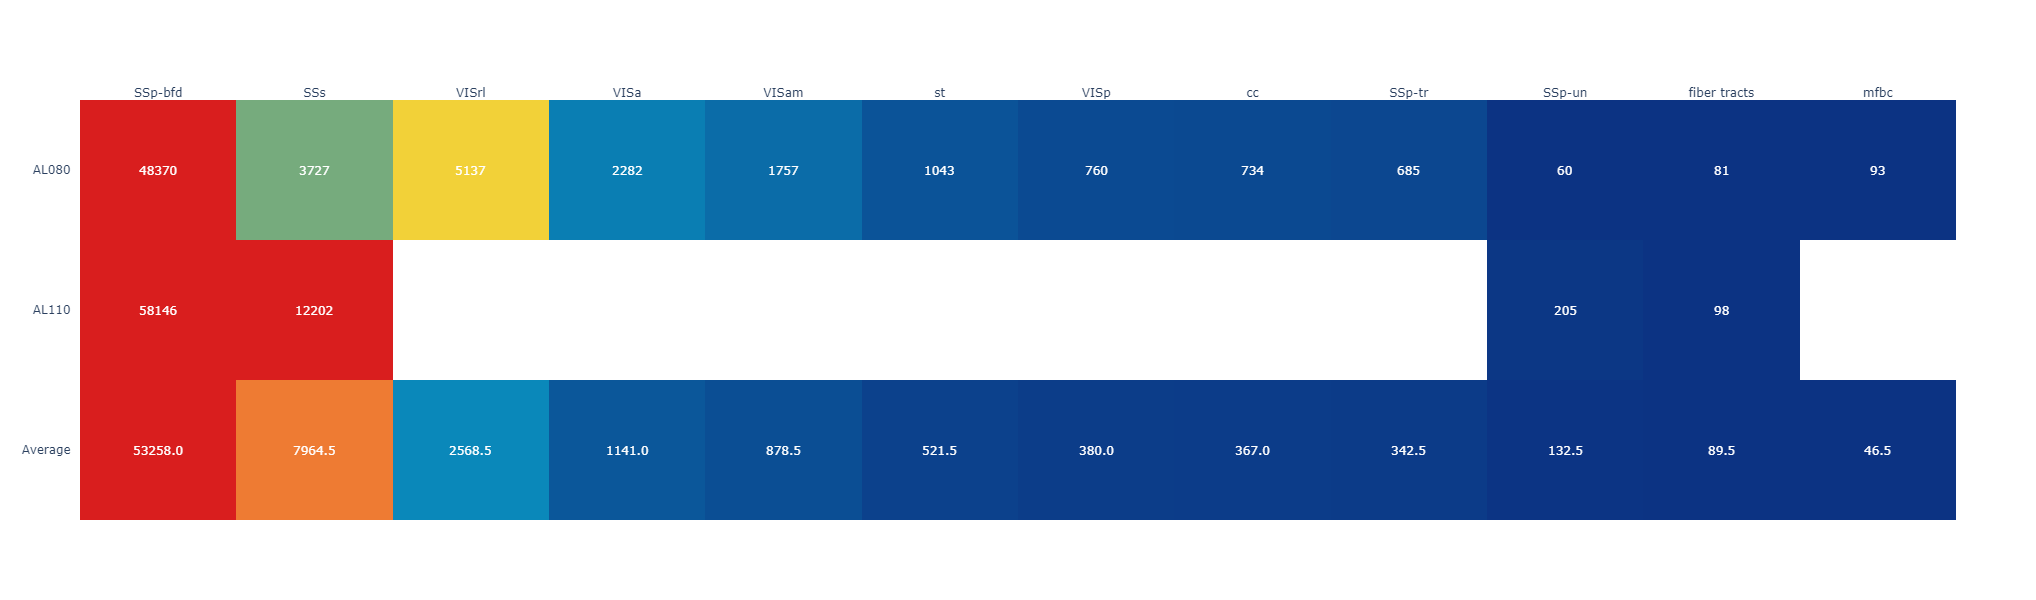

In [83]:

fig = ff.create_annotated_heatmap(z=final.values, 
                                  colorscale='Portland',
                                  font_colors=['white'],
                                  zmax= 10000,
                                  zmin=100,
                                  y=y,
                                  x=x,
                                  hoverongaps = False,
                                  text=full_name
                                 )
fig.update_xaxes(visible=True, showgrid=False)
fig.update_yaxes(visible=True, showgrid=False)

fig.update_layout(
    width = 2000, height = 600,
    autosize = True,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

fig.write_image(out_dir+"/heatmap.svg")

## End of section 5